<a href="https://colab.research.google.com/github/alefefreire/MLtraining/blob/master/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path=r'/content/drive/My Drive/Data/'

df=pd.read_csv(path+'machine_temperature_system_failure.csv')

In [3]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
timestamp    22695 non-null object
value        22695 non-null float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [0]:
df.timestamp=pd.to_datetime(df.timestamp)
df.value=df.value.astype(float)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
timestamp    22695 non-null datetime64[ns]
value        22695 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB


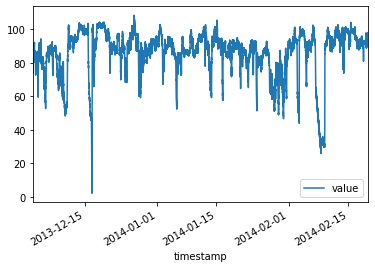

In [7]:
df.plot(x='timestamp',y='value')

# Featuring Enginering

In [0]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
#hour
df['hours']=df['timestamp'].dt.hour
#if it is during the day or the night
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [9]:
df.head()

,timestamp,value,time_epoch,hours,daylight,DayOfTheWeek,WeekDay
0,2013-12-02 21:15:00,73.967322,13860189,21,1,0,1
1,2013-12-02 21:20:00,74.935882,13860192,21,1,0,1
2,2013-12-02 21:25:00,76.124162,13860195,21,1,0,1
3,2013-12-02 21:30:00,78.140707,13860198,21,1,0,1
4,2013-12-02 21:35:00,79.329836,13860201,21,1,0,1


In [0]:
df_copy=df.copy()

# Anomaly detection

## Isolation Forest

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline

#pipeline
pip=Pipeline([('std',StandardScaler()),('Iso_forest',IsolationForest(contamination=outliers_fraction))])


In [12]:
pip.fit(df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']].values.reshape(-1,1))

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Iso_forest',
                 IsolationForest(behaviour='deprecated', bootstrap=False,
                                 contamination=0.01, max_features=1.0,
                                 max_samples='auto', n_estimators=100,
                                 n_jobs=None, random_state=None, verbose=0,
                                 warm_start=False))],
         verbose=False)

In [0]:
df['anomaly'] = pd.Series(pip.predict(df['value'].values.reshape(-1,1)))
df['anomaly']=df['anomaly'].map({1:0,-1:1})# anomaly==1

In [14]:
#number of anomalies
df['anomaly'].value_counts()

0    21578
1     1117
Name: anomaly, dtype: int64

In [15]:
df.head()

,timestamp,value,time_epoch,hours,daylight,DayOfTheWeek,WeekDay,anomaly
0,2013-12-02 21:15:00,73.967322,13860189,21,1,0,1,0
1,2013-12-02 21:20:00,74.935882,13860192,21,1,0,1,0
2,2013-12-02 21:25:00,76.124162,13860195,21,1,0,1,0
3,2013-12-02 21:30:00,78.140707,13860198,21,1,0,1,0
4,2013-12-02 21:35:00,79.329836,13860201,21,1,0,1,0


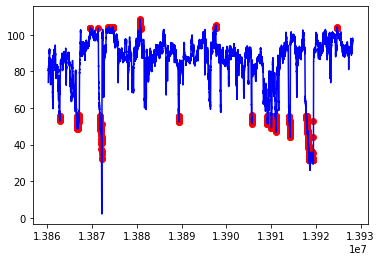

In [16]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

## One Class SVM

In [0]:
from sklearn.svm import OneClassSVM

In [0]:
#pipeline
pip=Pipeline([('std',StandardScaler()),('one_SVM',OneClassSVM(nu=0.95 * outliers_fraction))])


In [0]:
#Taking the original df
df=df_copy

In [20]:
pip.fit(df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']].values.reshape(-1,1))

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('one_SVM',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale',
                             kernel='rbf', max_iter=-1, nu=0.0095,
                             shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [0]:
df['anomaly'] = pd.Series(pip.predict(df['value'].values.reshape(-1,1)))
df['anomaly']=df['anomaly'].map({1:0,-1:1})# anomaly==1

In [24]:
#number of anomalies
df['anomaly'].value_counts()

0    21968
1      727
Name: anomaly, dtype: int64

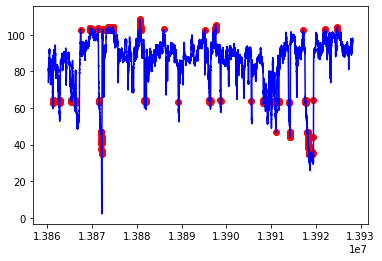

In [26]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()